In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def kalman_filter(
    y,
    A,
    H,
    P0,
    x0,
    cov_transition,
    cov_observation
):
    # Kalman Filter quantities initialization
    P_pri = P0
    P_post = np.array([])
    x_pri = x0
    x_post = np.array([])
    
    # Shapes
    n_states = len(x0)
    n_obs = y.shape[0]
    
    # Kalman filter loop
    results = pd.DataFrame()
    for k in range(y.shape[-1]):
        
        # Get Kalman gain from a priori estimations
        Q = P_pri@np.transpose(H)@np.linalg.inv(H@P_pri@np.transpose(H) + cov_observation)
        
        # Get a posteriori estimation for x
        x_post = x_pri + Q@(y[:,k] - H@x_pri)
        
        # Get a posteriori error covariance matrix
        P_post = (np.eye(n_states) + Q@H)@P_pri
        
        # Log results for iteration
        results = pd.concat(
            [
                
                results,
                pd.DataFrame(
                    index=[k],
                    data={
                        'iteration': [k+1],
                        'x_prior': [x_pri],
                        'x_posterior': [x_post],
                        'kalman_gain': [Q],
                        'P_prior': [P_pri],
                        'P_posterior': [P_post]
                    }
                )
            ],
            axis=0
        )
        
        # Get a priori state estimate for next iteration
        x_pri = A@x_post
        
        # Get a priori error cov estimate for next iteration
        P_pri = A@P_post@np.transpose(A) + cov_transition
        
    return results

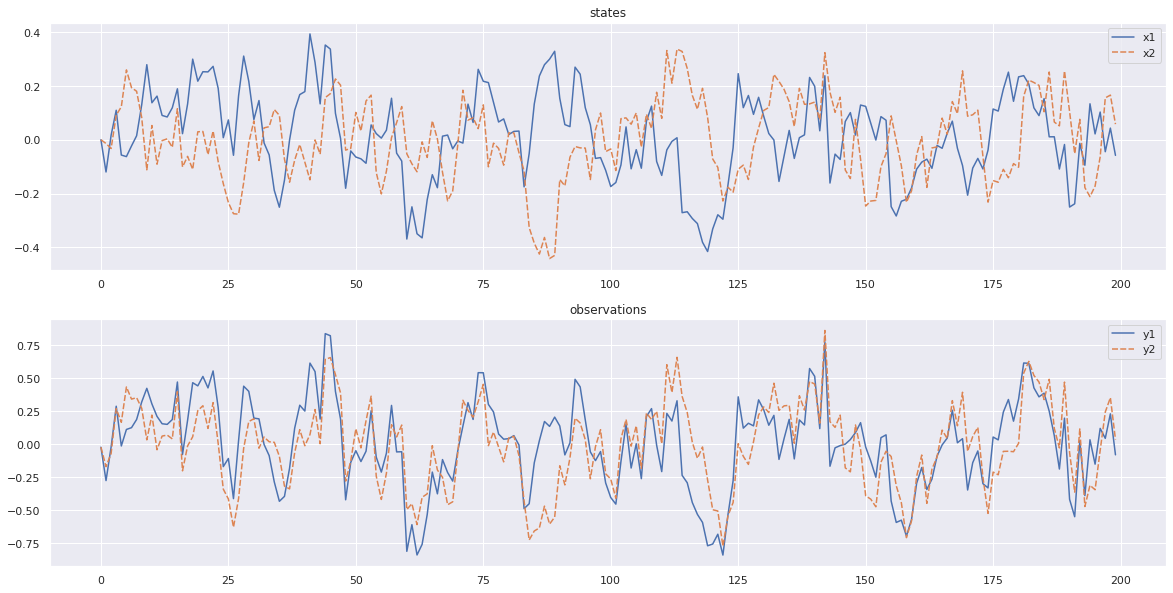

In [3]:
N_ITERS = 200
STATE_NOISE_STD = 0.1
MEAS_NOISE_STD = 0.1
TRANSITION_DAMPING = 0.7

# Transition matrix
A = np.array([
    [TRANSITION_DAMPING, -TRANSITION_DAMPING/3],
    [TRANSITION_DAMPING/5, TRANSITION_DAMPING]
])

# State noise covariance matrix
state_noise_cov = np.eye(2)*np.square(STATE_NOISE_STD)

# Generate AR(1) states
x_true = [[0, 0]]
for i, w in enumerate(
    np.random.normal(
        0,
        STATE_NOISE_STD,
        (N_ITERS-1, 2)
    )
):
    x_true.append(
        list(A@np.transpose(x_true[i]) + w.T)
    )

x_true = np.array(x_true).T
    
# Measurement matrix: y will be the difference and sum of AR(1) processes
H = np.array([
    [2, 1],
    [1, 2]
])

# Measurement covariance matrix
meas_noise_cov = np.eye(2)*np.square(MEAS_NOISE_STD)

# Generate observed y
y_true = H@x_true + np.random.normal(0, MEAS_NOISE_STD)

# Plot x and y
plot_df = pd.DataFrame(
    data={
        'it': range(N_ITERS),
        'x1': x_true[0, :],
        'x2': x_true[1, :],
        'y1': y_true[0, :],
        'y2': y_true[1, :],
    }
)

fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(20,10)
)

# states
sns.lineplot(
    data=plot_df[['x1', 'x2']],
    ax=ax1
)
t1 = ax1.set_title('states')

# observations
sns.lineplot(
    data=plot_df[['y1', 'y2']],
    ax=ax2
)
t2 = ax2.set_title('observations')

In [4]:
res = kalman_filter(
    y=y_true,
    A=A,
    H=H,
    P0=np.eye(2),
    x0=np.array([0, 0]).T,
    cov_transition=state_noise_cov,
    cov_observation=meas_noise_cov
)
res

,iteration,x_prior,x_posterior,kalman_gain,P_prior,P_posterior
0,1,"[0, 0]","[-0.007380944652989356, -0.007380944652989359]","[[0.6615311919649234, -0.3285678179360667], [-...","[[1.0, 0.0], [0.0, 1.0]]","[[1.99449456599378, 0.004395556092789965], [0...."
1,2,"[-0.003444440838061698, -0.0061999935085110605]","[-0.12676112474706833, -0.0217072311158078]","[[0.6623610620386013, -0.3293246763296877], [-...","[[1.094455604272969, -0.12829674399182434], [-...","[[2.1833977192112477, -0.25219011993465584], [..."
2,3,"[-0.08366776672925934, -0.03294161924565502]","[0.009416704144445731, -0.03950864231768304]","[[0.6630407961301839, -0.329763610939518], [-0...","[[1.2738036058101472, -0.23603182435469292], [...","[[2.5420877276096285, -0.4676550886493553], [-..."
3,4,"[0.01581037610857139, -0.026337711042155723]","[0.10251677398286249, 0.08365220580063955]","[[0.6634769416581725, -0.32987223571488583], [...","[[1.5177818728669705, -0.29292433537495194], [...","[[3.030040992003837, -0.5814379327062775], [-0..."
4,5,"[0.052242893767854515, 0.07290889241804842]","[-0.06375617201368088, 0.11500239802171705]","[[0.6636424914505946, -0.32971645427176693], [...","[[1.7880932398748577, -0.2792772180014104], [-...","[[3.5706631416258054, -0.5541441846695071], [-..."
...,...,...,...,...,...,...
195,196,"[0.13961429159366998, -0.13558784802443874]","[0.014351497194360185, -0.1799606746413817]","[[0.6666658004513023, -0.333332336491278], [-0...","[[9548.968712925316, 1302.5343504149992], [130...","[[19097.93187030417, 2605.0731452649143], [260..."
196,197,"[0.05203687211904119, -0.12396326264175675]","[0.09571627705931246, -0.07101422313630229]","[[0.6666658097437523, -0.33333240172510503], [...","[[9028.775638136143, 1497.67536097005], [1497....","[[18057.545720725542, 2995.3551663754783], [29..."
197,198,"[0.08357137933998925, -0.03630967740710786]","[-0.05184444076730675, 0.14830138662637524]","[[0.6666658561811745, -0.3333325004972344], [-...","[[8477.416973284779, 1316.4384699510701], [131...","[[16954.82839102218, 2632.881384338333], [2632..."
198,199,"[-0.07089476541660228, 0.09655274893103971]","[0.03601886402511156, 0.1588548901251646]","[[0.6666659327310377, -0.33333261419777993], [...","[[8145.806876077481, 771.6609520095026], [771....","[[16291.608196606698, 1543.3263484562103], [15..."


In [5]:
def proc_results(
    x_true,
    results
):
    res_proc = pd.DataFrame()
    # Get true and estimated (prior, posterior) states in iterations
    for i, row in results.iterrows():
        res_proc = pd.concat(
            [
                res_proc,
                pd.DataFrame(
                    index=[i],
                    data={
                        'iteration': [row['iteration']],
                        'x1_true': x_true[:, i][0],
                        'x2_true': x_true[:, i][1],
                        'x1_prior': [row['x_prior'][0]],
                        'x2_prior': [row['x_prior'][1]],
                        'x1_posterior': [row['x_posterior'][0]],
                        'x2_posterior': [row['x_posterior'][1]],
                    }
                )
            ]
        )
        
    # Plot estimations
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20,10)
    )
    
    # X1
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_true'].values,
        label='true'
    )
    ax1.scatter(
        res_proc['iteration'].values,
        res_proc['x1_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_posterior'].values,
        linestyle='--',
        marker='x',
        label='posterior'
    )
    ax1.legend()
    ax1.set_title('x1')
    
    # X2
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_true'].values,
        label='true'
    )
    ax2.scatter(
        res_proc['iteration'].values,
        res_proc['x2_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_posterior'].values,
        marker='x',
        linestyle='--',
        label='posterior'
    )
    ax2.legend()
    ax2.set_title('x2')
        
    return res_proc

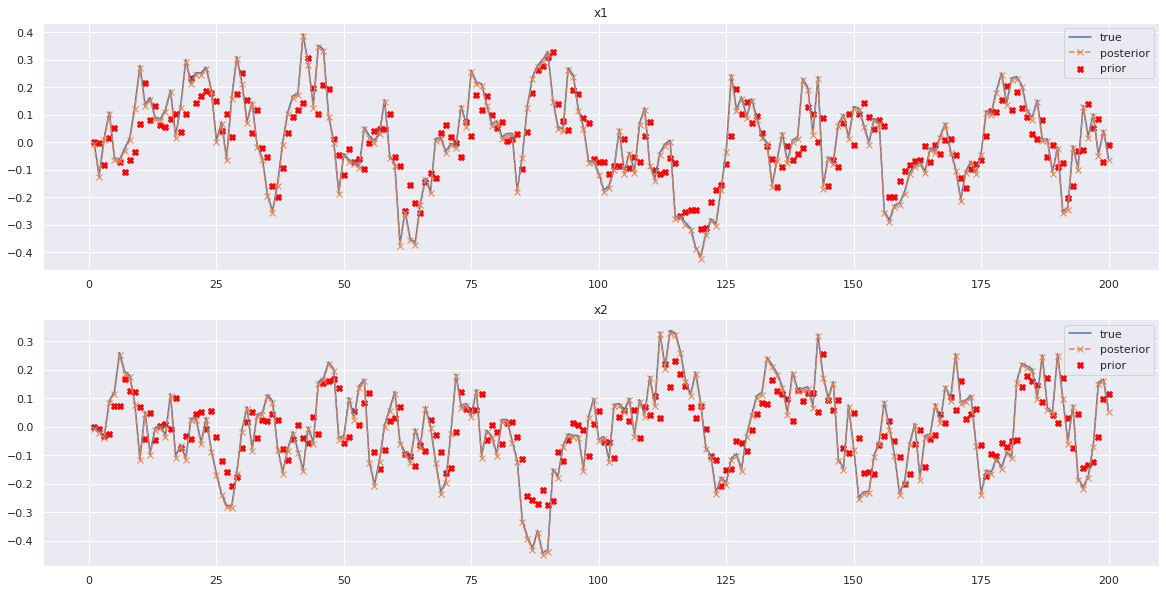

In [6]:
proc_results = proc_results(
    x_true=x_true,
    results=res
)